# Différentes approches MLP pour analyser le sentiment d'un avis amazon


#### Alexis Mérienne

#### 9 octobre 2022

In [1]:
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu

add_notebook_menu()

## Imports

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [5]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [6]:
import nltk
from nltk import word_tokenize          
from nltk import FreqDist

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TextVectorization, Dropout, Flatten, Embedding, LSTM, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

You should consider upgrading via the 'C:\Users\alexi\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Datasets

In [9]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz",encoding='utf-8')
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz",encoding='utf-8')
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz",encoding='utf-8')

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
reviews_tokenized = [word_tokenize(review) for review in TRAIN['Reviews']]
flatten_reviews = [item for sublist in reviews_tokenized for item in sublist]

In [12]:
vocabulary_size = len(set(flatten_reviews))
print("La taille du vocabulaire de notre dataset est : \nvacabulary_size = ",vocabulary_size)

La taille du vocabulaire de notre dataset est : 
vacabulary_size =  13099


In [13]:
len_words = [len(w) for w in flatten_reviews]
freqDist2 = FreqDist(len_words)
freqDist2

FreqDist({3: 44720, 4: 38709, 2: 37348, 1: 36588, 5: 25285, 6: 14777, 7: 13142, 8: 7393, 9: 4825, 10: 2905, ...})

In [14]:
# On construit X_train et y_train
# On encode les avis en ASCII, pour éviter des soucis de lectures du texte dans les modèles d'apprentissage
X_train = TRAIN['Reviews'].fillna("").str.encode('ascii', 'ignore').str.decode('ascii')
y_train = TRAIN['Rating']
X_train.shape, y_train.shape, y_train[0]

((5000,), (5000,), 4)

In [15]:
# On construit X_val et y_val
# Ces valeurs permettent de tester la précision de notre modèle pendant la phase d'apprentissage
# On sépare X_val et X_test pour que les métrics mesurées pendant la phase d'apprentissage n'influence pas l'évaluation du modèle
X_val = VAL['Reviews'].fillna("").str.encode('ascii', 'ignore').str.decode('ascii')
y_val = VAL['Rating']
X_val.shape, y_val.shape

((1000,), (1000,))

In [16]:
# On construit X_test et y_test, qui vont nous permettent d'évaluer nos modèles
X_test = TEST['Reviews'].fillna("").str.encode('ascii', 'ignore').str.decode('ascii')
y_test = TEST['Rating']
X_test.shape, y_test.shape

((1000,), (1000,))

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

## 1) Preprocessing

### On convertit le texte du corpus en minuscule

La convertion du texte en minuscule est pertinente pour homogénéiser le dataset. Par exemple le mots en début de phrase auront la même sémentique que les mots en milieu de phrase 

In [18]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

#On transforme tous les mots en minuscule
X_train_prep,X_val_prep,X_test_prep = [r.lower() for r in X_train],[r.lower() for r in X_val],[r.lower() for r in X_test]

#On supprime les signes de ponctuation, qui ne transmettent pas d'information sémentique. 
X_train_prep,X_val_prep,X_test_prep = [tokenizer.tokenize(r) for r in X_train_prep],[tokenizer.tokenize(r) for r in X_val_prep],[tokenizer.tokenize(r) for r in X_test_prep]


### Stemming and Lemmatization with NLTK

In [19]:
from nltk.stem import PorterStemmer

stemmer_ps = PorterStemmer()  
#Stemmer transforme les mots en les associant à leur radical. On diminue ainsi la taille du dataset sans perdre d'information 
#sémantique

X_train_prep = [[stemmer_ps.stem(word) for word in review] for review in X_train_prep]
X_val_prep = [[stemmer_ps.stem(word) for word in review] for review in X_val_prep]
X_test_prep = [[stemmer_ps.stem(word) for word in review] for review in X_test_prep]

### stopwords 

Les 'stopwords' sont les mots de liaisons renfermant peut d'information dans une phrase. Ici, j'ai fait le choix de les stocker dans d'autres variables pour évaluer différentes stratégies. 
En effet, il se pourrait que ce ne soit pas une bonne idée de les supprimer du corpus puisqu'ils peuvent la fonction d'indiquer une négation dans la phrase. Etant donné que nous faisons de l'analyse de sentiment, cette fonction est primordiale.

In [20]:
nltk.download('stopwords')
from nltk.corpus import stopwords

english_stopwords = stopwords.words('english')

X_train_prep_sp = [[t for t in review if t not in english_stopwords]for review in X_train_prep]
X_val_prep_sp = [[t for t in review if t not in english_stopwords]for review in X_val_prep]
X_test_prep_sp = [[t for t in review if t not in english_stopwords] for review in X_test_prep]

for k in range(5):
    print(X_train_prep_sp[k]) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['love', 'absolut', 'love']
['love', 'blu', 'phone', 'thi', 'second', 'one', 'thi', 'year', 'becaus', 'anyth', 'wrong', 'blu', 'studio', '6', '0', 'hd', 'opt', 'upgrad', 'phone', 'slightli', 'smaller', 'screen', 'better', 'batteri', 'life', 'price', 'phone', 'cannot', 'go', 'wrong', '1', 'setup', 'breeze2', 'custom', 'easy3', 'color', 'vibrant4', 'phone', 'light', 'even', 'rug', 'case', '5', 'batteri', 'life', 'better', 'ani', 'phone', 'ever', 'had6', 'screen', 'respons', 'touch', 'unlik', 'phone', 'issu', 'volum', 'music', 'playback', 'review', 'note', 'great', 'phone', 'littl', 'price', 'everyon', 'give', 'blu', 'tri']
['great', 'phone']
['veri', 'happi', 'perform', 'app', 'work', 'flawlessli', 'camera', 'could', 'better', 'complaint', 'consid', 'onli', '50']
['easi', 'use', 'great', 'price']


On convertit notre dataset d'une liste de Token à une liste de phrase

In [21]:
X_train_prep = [' '.join([str(elem) for elem in review]) for review in X_train_prep]
X_val_prep= [' '.join([str(elem) for elem in review]) for review in X_val_prep]
X_test_prep = [' '.join([str(elem) for elem in review]) for review in X_test_prep]

X_train_prep_sp = [' '.join([str(elem) for elem in review]) for review in X_train_prep_sp]
X_val_prep_sp = [' '.join([str(elem) for elem in review]) for review in X_val_prep_sp]
X_test_prep_sp = [' '.join([str(elem) for elem in review]) for review in X_test_prep_sp]


for k in range(5):
    print('w/o stopword : ',X_train_prep[k], ' w/ stopword :',X_train_prep_sp[k])

w/o stopword :  i love it i absolut love it  w/ stopword : love absolut love
w/o stopword :  i love the blu phone thi is my second one thi year and not becaus there is anyth wrong with my blu studio 6 0 hd i have just opt to upgrad to a phone with a slightli smaller screen and better batteri life for the price of these phone you cannot go wrong 1 setup is a breeze2 custom is easy3 color are vibrant4 phone is light even with a rug case 5 batteri life is better than ani phone i have ever had6 screen is respons to touch unlik some other phone i have had no issu with volum or music playback as other review have note all in all a great phone for a littl price everyon should give blu a tri  w/ stopword : love blu phone thi second one thi year becaus anyth wrong blu studio 6 0 hd opt upgrad phone slightli smaller screen better batteri life price phone cannot go wrong 1 setup breeze2 custom easy3 color vibrant4 phone light even rug case 5 batteri life better ani phone ever had6 screen respons 

## 2) Baseline

Notre baseline est composée d'une simple régression linéaire sur les données d'entrainement que l'on convertit en BOW. 
Le Bag Of Word est une représentation véctorielle simple de données textuelle. Ici, cette représentation se fait à l'aide de la fonction CountVectorize()

Le Bag Of Word est une matrice de taille N * M. 
avec 

N la taille du vocabulaire
M la taille du dataset

Un review est représentée sous la forme d'un vecteur dont les éléments sont le nombre d'occurance d'un mot. 

In [22]:
#Nombre de classes présente dans le dataset.
#Les utilisateurs peuvent noter les produits avec une note allant de 1 à 5. Donc le nombre de classe est 5
nb_classes = len(np.unique(y_train))

In [23]:
# Je construit la pipeline
lr_pipeline = Pipeline([
        ('feature_extraction',  CountVectorizer()),
        ('classification',  LogisticRegression(multi_class='auto', max_iter=400))
        ])


### 1 - Sans supression des stopwords

In [25]:
# J'entraine le modèle
lr_pipeline.fit(X_train_prep, y_train)

# J'évalue le modèle
y_pred_baseline = lr_pipeline.predict(X_test_prep)
print(classification_report(y_pred_baseline, y_test))

              precision    recall  f1-score   support

           1       0.64      0.64      0.64       157
           2       0.18      0.29      0.22        31
           3       0.17      0.26      0.21        46
           4       0.29      0.45      0.35       105
           5       0.91      0.76      0.83       661

    accuracy                           0.67      1000
   macro avg       0.44      0.48      0.45      1000
weighted avg       0.74      0.67      0.70      1000



In [26]:
#Je calcule son F1 score
f1_baseline = round(f1_score(y_pred_baseline,y_test,average='weighted'),2)
print('f1 score',f1_baseline)

f1 score 0.7


### 2 - Avec la supression des stopwords

In [27]:
# J'entraine le modèle
lr_pipeline.fit(X_train_prep_sp, y_train)

# J'évalue le modèle
y_pred_sp = lr_pipeline.predict(X_test_prep_sp)
print(classification_report(y_pred_sp, y_test))

              precision    recall  f1-score   support

           1       0.62      0.62      0.62       157
           2       0.12      0.19      0.15        31
           3       0.14      0.20      0.17        50
           4       0.18      0.35      0.23        84
           5       0.90      0.74      0.81       678

    accuracy                           0.64      1000
   macro avg       0.39      0.42      0.40      1000
weighted avg       0.73      0.64      0.68      1000



In [28]:
#Je calcule son score f1
f1_baseline_sp = round(f1_score(y_pred_sp,y_test,average='weighted'),2)
print('f1 score :',f1_baseline_sp)

f1 score : 0.68


### Conclusion 

La stratégie la plus précise est celle avec les stopwords, comme notre intuition l'avait prédit. 

Pour les autres approches nous utliseront donc le prepocessing sans les stopwords. 

## 3) Approche 1


La première approche est de construire un MLP avec l'information de notre dataset encodée dans un BOW.

In [29]:
#On enocde les données d'entré en BOW. 
cv = CountVectorizer()
X_train_encoded = cv.fit_transform(X_train_prep).toarray()
X_val_encoded = cv.transform(X_val_prep).toarray()
X_test_encoded = cv.transform(X_test_prep).toarray()

In [30]:
#OneHotEncoder est une fonction de sklearn qui encode un dataset d'entier en un dataset de vecteurs orthogonaux
#Ici les données de sorties sont des entiers compris entre 0 et 4. 
#Donc, après encodage, les données seront des vecteurs unitaires de taille n = 5
#Ainsi, 3 -encodage-> [0,0,0,1,0]

enc = OneHotEncoder()
y_train = np.array(y_train).reshape(-1,1)
enc.fit(y_train)


y_train_encoded = enc.transform(np.array(y_train).reshape(-1,1)).toarray()
y_val_encoded = enc.transform(np.array(y_val).reshape(-1,1)).toarray()
y_test_encoded = enc.transform(np.array(y_test).reshape(-1,1)).toarray()

y_train_encoded.shape

(5000, 5)

In [31]:
# Définitions de constantes

#feature_vector_length est le nombre de review dans les données d'entrainements
feature_vector_length = X_train_encoded.shape[1]
feature_vector_length, nb_classes

(6646, 5)

#### Construction du premier modèle

J'ai tout d'abord construit un modèle simple, composé d'une couche cachée. Ce modèle divergeait à partir d'un 5 à 10 epochs. 
Pour ralentir l'apprentissage, j'ai diminué le nombre de neurones dans la couche cachée.

Une autre solution pour diminuer la vitesser d'apprentissage est d'utiliser du dropout. Cependant, le risque lorsqu'on utilise du dropout est de diminuer la qualité de l'apprentissage, étant donné que l'on supprime des aléatoirement des entrées dans la couche Dense. 

In [32]:
inputs_ = tf.keras.Input(shape=(feature_vector_length,))

h = Dense(12, activation='relu')(inputs_)

output_ = Dense(nb_classes, activation='softmax')(h)

model_appr_1 = Model(inputs_, output_)

model_appr_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6646)]            0         
                                                                 
 dense (Dense)               (None, 12)                79764     
                                                                 
 dense_1 (Dense)             (None, 5)                 65        
                                                                 
Total params: 79,829
Trainable params: 79,829
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor="val_accuracy", min_delta=0.0005, patience=200, verbose=1, mode="auto",
                                restore_best_weights=True)
                 ]

model_appr_1.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
history_appr_1 = model_appr_1.fit(X_train_encoded, y_train_encoded,
                    validation_data=(X_val_encoded, y_val_encoded),
                    epochs=30, batch_size=250,
                    callbacks=callbacks_list, verbose=1)

Epoch 1/30
20/20 [==============================] - 1s 29ms/step - loss: 1.5590 - accuracy: 0.4588 - val_loss: 1.5022 - val_accuracy: 0.5590
Epoch 2/30
20/20 [==============================] - 0s 19ms/step - loss: 1.4443 - accuracy: 0.5382 - val_loss: 1.4033 - val_accuracy: 0.5590
Epoch 3/30
20/20 [==============================] - 0s 19ms/step - loss: 1.3268 - accuracy: 0.5570 - val_loss: 1.3125 - val_accuracy: 0.5820
Epoch 4/30
20/20 [==============================] - 0s 19ms/step - loss: 1.2100 - accuracy: 0.6140 - val_loss: 1.2397 - val_accuracy: 0.6130
Epoch 5/30
20/20 [==============================] - 0s 19ms/step - loss: 1.1138 - accuracy: 0.6450 - val_loss: 1.1770 - val_accuracy: 0.6240
Epoch 6/30
20/20 [==============================] - 0s 20ms/step - loss: 1.0353 - accuracy: 0.6696 - val_loss: 1.1308 - val_accuracy: 0.6390
Epoch 7/30
20/20 [==============================] - 0s 19ms/step - loss: 0.9712 - accuracy: 0.6838 - val_loss: 1.0962 - val_accuracy: 0.6480
Epoch 8/30
20

In [34]:
# plot history
def babysit(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    # summarize history for loss
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss train', 'loss val'], loc='best')

    # summarize history for loss
    ax2.plot(history.history['accuracy'], "-", c="blue")
    ax2.plot(history.history['val_accuracy'], "--", c="blue")
    ax2.set_title('model metrics')
    ax2.set_ylabel('score')
    ax2.set_xlabel('epoch')
    ax2.legend(['acc', 'val acc'], loc='best')

    plt.show()

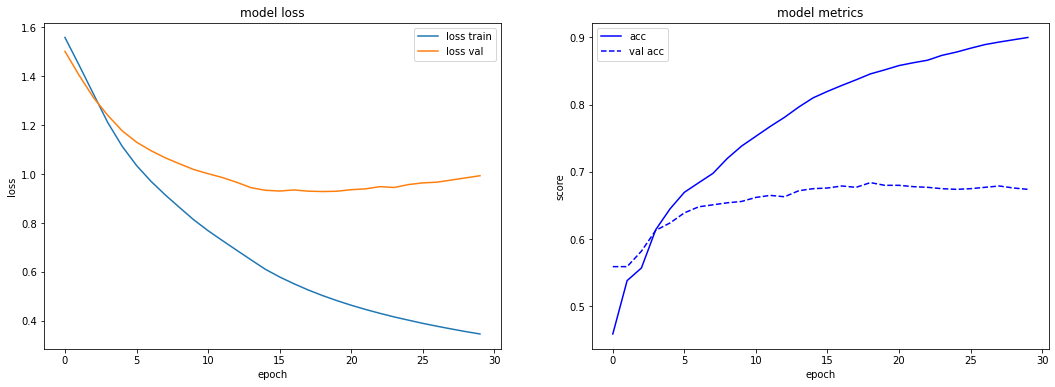

In [35]:
babysit(history_appr_1)

In [36]:
# On évalue le modèle
y_pred_encoded_ap_1 = model_appr_1.predict(X_test_encoded)
y_pred_ap_1 = np.argmax(y_pred_encoded_ap_1,axis=1) + 1

print(classification_report(y_test, y_pred_ap_1))

              precision    recall  f1-score   support

           1       0.68      0.68      0.68       159
           2       0.36      0.20      0.25        51
           3       0.30      0.21      0.25        71
           4       0.46      0.26      0.33       163
           5       0.76      0.91      0.83       556

    accuracy                           0.68      1000
   macro avg       0.51      0.45      0.47      1000
weighted avg       0.64      0.68      0.65      1000



In [37]:
f1_ap_1 = round(f1_score(y_test,y_pred_ap_1,average='weighted'),2)
print('f1 score :',f1_ap_1)

f1 score : 0.65


### Conclusion

Notre modèle est moins performant que notre baseline. Notre approche n'est pas optimale. En effet, les BOW ne permettent pas d'encoder le contexte d'un mot. 

## 4) Approche 2 

La deuxième approche est d'associer un MLP avec de l'embedding 

L'approche BOW présente un défaut principale, elle ne garde pas l'information de la place du mot dans la phrase. Or, connaître la position du mot dans la phrase revient à connaître son contexte sémentique.

L'embedding repose sur l'idée d'encoder les mots en fonction d'un corpus de vocabulaire et ainsi ratacher le mot à son contexte.

In [38]:
vocab_size = vocabulary_size

#Ici, on choisit que la longueur maximale de la description vectorielle d'un mot est la taille du vocubalaire à 90% le plus récurrent
n = 0.90
lengths = [len(txt.split()) for txt in X_train]
fdist = FreqDist(lengths)  

cumul = 0
for max_len in range(max(lengths)):
    cumul += fdist[max_len]
    if cumul>=n*len(X_train):
        break

embed_dim = 100 # embedding dimension : Dans la littérature, on retrouve le plus fréquemment des taille d'embedding de 50,100,200. 

In [39]:
vectorize_layer = TextVectorization(max_tokens=vocab_size,
              output_mode='int',
              output_sequence_length=max_len)

In [40]:
vectorize_layer.adapt(X_train)

In [41]:
input_ = Input(shape=(1, ), name="input", dtype=tf.string)

x = vectorize_layer(input_)

x = Embedding(vocab_size, embed_dim, name="Embedding")(x)

x = Flatten()(x)

x = Dropout(0.3)(x)

x = Dense(16, activation="relu", name="hidden")(x)

x = Dropout(0.2)(x)

output_ = Dense(nb_classes, activation='softmax', name="output")(x)

model_appr_2 = Model(input_, output_)

model_appr_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 96)               0         
 torization)                                                     
                                                                 
 Embedding (Embedding)       (None, 96, 100)           1309900   
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dropout (Dropout)           (None, 9600)              0         
                                                                 
 hidden (Dense)              (None, 16)                153616    
                                                           

In [42]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor="val_accuracy", min_delta=0.0005, patience=200, verbose=1, mode="auto",
                                restore_best_weights=True)
                 ]
model_appr_2.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [43]:
history_appr_2 = model_appr_2.fit(np.array(X_train_prep), y_train_encoded,
                    validation_data=(X_val,y_val_encoded),
                    epochs=20, batch_size=250,
                    callbacks=callbacks_list, verbose=1)

Epoch 1/20
20/20 [==============================] - 3s 109ms/step - loss: 1.3598 - accuracy: 0.4918 - val_loss: 1.2241 - val_accuracy: 0.5580
Epoch 2/20
20/20 [==============================] - 2s 86ms/step - loss: 1.2559 - accuracy: 0.5388 - val_loss: 1.1953 - val_accuracy: 0.5590
Epoch 3/20
20/20 [==============================] - 2s 90ms/step - loss: 1.1838 - accuracy: 0.5634 - val_loss: 1.1423 - val_accuracy: 0.5910
Epoch 4/20
20/20 [==============================] - 2s 90ms/step - loss: 1.0929 - accuracy: 0.6124 - val_loss: 1.0859 - val_accuracy: 0.6260
Epoch 5/20
20/20 [==============================] - 2s 89ms/step - loss: 0.9989 - accuracy: 0.6488 - val_loss: 1.0410 - val_accuracy: 0.6330
Epoch 6/20
20/20 [==============================] - 2s 91ms/step - loss: 0.9039 - accuracy: 0.6788 - val_loss: 0.9922 - val_accuracy: 0.6530
Epoch 7/20
20/20 [==============================] - 2s 108ms/step - loss: 0.8137 - accuracy: 0.7180 - val_loss: 0.9537 - val_accuracy: 0.6580
Epoch 8/20


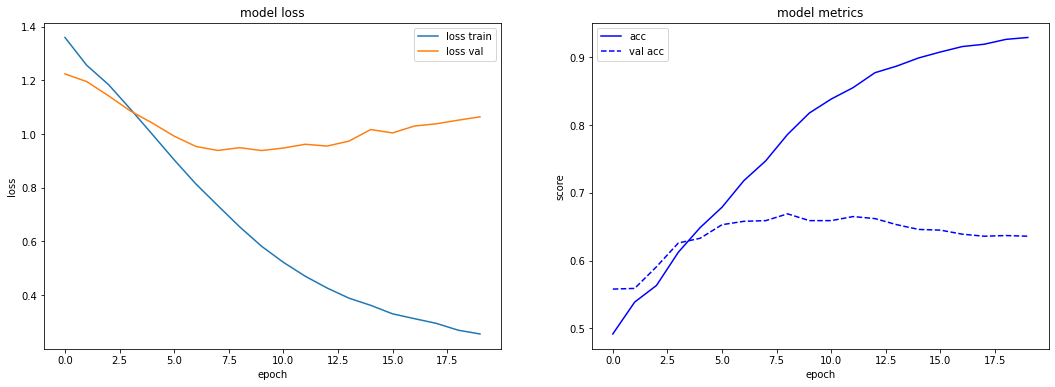

In [44]:
# Babysit the model
babysit(history_appr_2)

In [45]:
# Evaluate the model
y_pred_encoded_ap_2 = model_appr_2.predict(X_test)
y_pred_ap_2 = np.argmax(y_pred_encoded_ap_2,axis=1) + 1

print(classification_report(y_test, y_pred_ap_2))

              precision    recall  f1-score   support

           1       0.59      0.62      0.60       159
           2       0.15      0.10      0.12        51
           3       0.21      0.13      0.16        71
           4       0.34      0.21      0.26       163
           5       0.75      0.88      0.81       556

    accuracy                           0.64      1000
   macro avg       0.41      0.39      0.39      1000
weighted avg       0.59      0.64      0.61      1000



In [46]:
f1_ap_2 = round(f1_score(y_test,y_pred_ap_2,average="weighted"),2)
f1_ap_2

0.61

## 5) Approche 3

La troisième approche est également de l'embedding avec un corpus déjà existant. On ne le construit pas à partir de notre dataset.

On utilise le groupe d'algortithme Word2Vec.

Word2Vec fonctionne en construisant un embedding sur un large corpus et les poids associés aux vecteurs "mots" sont définis avec les contextes de ces mots dans le corpus. 

In [120]:
voc = vectorize_layer.get_vocabulary()
#Word index est un dictionnaire de notre dataset
word_index = dict(zip(voc, range(len(voc))))
len(word_index)

10927

In [48]:
texts_vec = vectorize_layer(X_train_prep)

In [136]:
# Download the pre-trained embeddin matrix for exemple from glove
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip -q glove.6B.zip

^C


[glove.6B.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
note:  glove.6B.zip may be a plain executable, not an archive
unzip:  cannot find zipfile directory in one of glove.6B.zip or
        glove.6B.zip.zip, and cannot find glove.6B.zip.ZIP, period.


In [116]:
#On importe notre matrice Word2Vec de taille 100. 
path_to_glove_file = "glove.6B.100d.txt"

#On construit un index répertoriant les  
embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs


In [125]:
# Build the corresponding matrix (cf. compagnon notebook)
num_tokens = len(voc) + 2 # UNK/OOV and PAD
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
voab_size_em  = embedding_matrix.shape[0]
voab_size_em

10929

In [126]:
# define the model
input_ = Input(shape=(1,), dtype=tf.string)

x = vectorize_layer(input_)

x = Embedding(voab_size_em, embed_dim,weights=[embedding_matrix], name="Embedding")(x)

x = Flatten()(x)

hidden_1 = Dense(12, activation="relu")(x)

dropout_1 = Dropout(0.3)(hidden_1)

output_ = Dense(nb_classes, activation='sigmoid')(dropout_1)

model_ap_3 = Model(input_, output_)

model_ap_3.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 96)               0         
 torization)                                                     
                                                                 
 Embedding (Embedding)       (None, 96, 100)           1092900   
                                                                 
 flatten_8 (Flatten)         (None, 9600)              0         
                                                                 
 dense_16 (Dense)            (None, 12)                115212    
                                                                 
 dropout_8 (Dropout)         (None, 12)                0         
                                                           

In [127]:
model_ap_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
# fit model using ealy stopping
callbacks_list = [EarlyStopping(monitor="val_accuracy", min_delta=0.0005, patience=200, verbose=1, mode="auto",
                                restore_best_weights=True)]

history_ap_3 = model_ap_3.fit(np.array(X_train_prep), y_train_encoded,
                    validation_data=(np.array(X_val_prep),y_val_encoded),
                    epochs=20, batch_size=250,
                    callbacks=callbacks_list, verbose=1)

Epoch 1/20
20/20 [==============================] - 2s 65ms/step - loss: 1.4992 - accuracy: 0.4488 - val_loss: 1.3764 - val_accuracy: 0.5550
Epoch 2/20
20/20 [==============================] - 1s 50ms/step - loss: 1.3375 - accuracy: 0.5322 - val_loss: 1.2383 - val_accuracy: 0.5770
Epoch 3/20
20/20 [==============================] - 1s 53ms/step - loss: 1.2175 - accuracy: 0.5620 - val_loss: 1.1688 - val_accuracy: 0.5770
Epoch 4/20
20/20 [==============================] - 1s 58ms/step - loss: 1.1365 - accuracy: 0.5698 - val_loss: 1.1508 - val_accuracy: 0.5830
Epoch 5/20
20/20 [==============================] - 1s 54ms/step - loss: 1.0579 - accuracy: 0.5822 - val_loss: 1.1102 - val_accuracy: 0.5950
Epoch 6/20
20/20 [==============================] - 1s 58ms/step - loss: 1.0193 - accuracy: 0.5936 - val_loss: 1.0924 - val_accuracy: 0.6020
Epoch 7/20
20/20 [==============================] - 1s 50ms/step - loss: 0.9665 - accuracy: 0.5992 - val_loss: 1.0756 - val_accuracy: 0.6040
Epoch 8/20
20

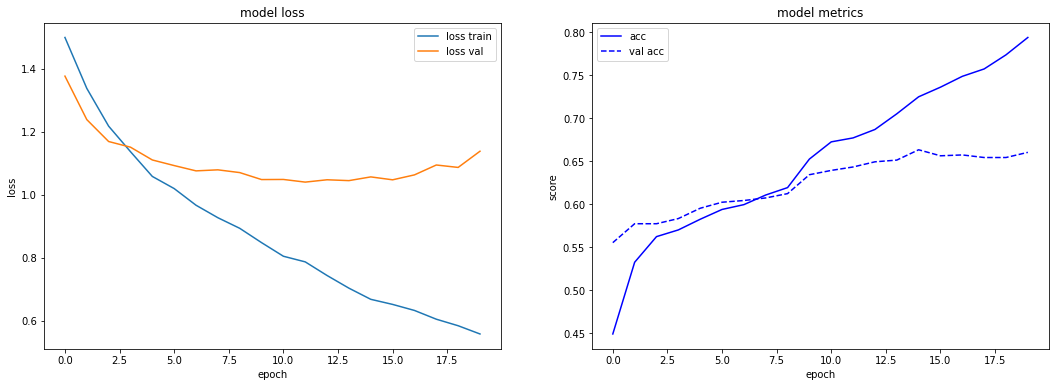

In [129]:
# Babysit the model
babysit(history_ap_3)

In [130]:
# Evaluate the model
y_pred_encoded_ap_3 = model_ap_3.predict(X_test)
y_pred_ap_3 = np.argmax(y_pred_encoded_ap_3,axis=1) + 1

print(classification_report(y_test, y_pred_ap_3))

              precision    recall  f1-score   support

           1       0.54      0.46      0.50       159
           2       0.17      0.02      0.04        51
           3       0.15      0.06      0.08        71
           4       0.41      0.12      0.19       163
           5       0.67      0.95      0.78       556

    accuracy                           0.62      1000
   macro avg       0.39      0.32      0.32      1000
weighted avg       0.55      0.62      0.55      1000



In [131]:
f1_ap_3 = round(f1_score(y_test,y_pred_ap_3,average="weighted"),2)
f1_ap_3

0.55

Le résultat est très insatisfaisant, nous n'allons donc pas garder cette stratégie d'embedding pour l'approche 4
Ce résulat peut s'expliquer par le fait que le corpus utilisé pour construire notre embedding n'est pas adapté à notre dataset. 

## 6) Approche 4 

MLP avec des réseaux de neuronnes récurrents

In [57]:
recurrent_size = 64 # Recurrent size
hidden_size = recurrent_size//4    # Hidden layer
dropout_rate = 0.3   # Dropout rate for regularization

In [93]:
# Définnission du MLP

input_ = Input(shape=(1,), dtype=tf.string)

x = vectorize_layer(input_)

x = Embedding(vocab_size, embed_dim, name="Embedding")(x)

#On ajoute la couche RNN avec l'option return_sequences
#La couche renvoie donc un tensor à chaque récurrence. 
#Le nombre de tensor en sortie est donc égale à recurrent_size
x = LSTM(recurrent_size, return_sequences=True,
         dropout=dropout_rate, recurrent_dropout=dropout_rate)(x)

#L'AveragePooling réduit la dimension de sortie en faisant une moyenne sur tous les tensor. 
x = AveragePooling1D(pool_size=recurrent_size)(x)

x = Flatten()(x)

hidden = Dense(32, activation="relu")(x)

dropout = Dropout(0.3)(hidden)

output_ = Dense(nb_classes, activation='softmax', dtype=tf.float64)(hidden)

model_ap_4 = Model(input_, output_)
    
model_ap_4.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 96)               0         
 torization)                                                     
                                                                 
 Embedding (Embedding)       (None, 96, 100)           1309900   
                                                                 
 lstm_5 (LSTM)               (None, 96, 64)            42240     
                                                                 
 average_pooling1d_3 (Averag  (None, 1, 64)            0         
 ePooling1D)                                                     
                                                                 
 flatten_7 (Flatten)         (None, 64)                0   

In [94]:
# Compile the model
f1 = F1Score(num_classes=nb_classes, average="weighted", threshold=None)
model_ap_4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", f1])

In [102]:
# fit model using ealy stopping
es = EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=1)
history_ap_4 = model_ap_4.fit(np.array(X_train_prep), y_train_encoded,
                    validation_data=(np.array(X_val_prep), y_val_encoded), 
                    epochs=50, callbacks=[es], verbose=1)

Epoch 1/50
157/157 [==============================] - 17s 106ms/step - loss: 0.6785 - accuracy: 0.7590 - f1_score: 0.7378 - val_loss: 1.0415 - val_accuracy: 0.6590 - val_f1_score: 0.6282
Epoch 2/50
157/157 [==============================] - 16s 101ms/step - loss: 0.6324 - accuracy: 0.7782 - f1_score: 0.7595 - val_loss: 1.0138 - val_accuracy: 0.6370 - val_f1_score: 0.6190
Epoch 3/50
157/157 [==============================] - 18s 116ms/step - loss: 0.5979 - accuracy: 0.7938 - f1_score: 0.7777 - val_loss: 1.0403 - val_accuracy: 0.6610 - val_f1_score: 0.6360
Epoch 4/50
157/157 [==============================] - 17s 107ms/step - loss: 0.5679 - accuracy: 0.8022 - f1_score: 0.7881 - val_loss: 1.0782 - val_accuracy: 0.6580 - val_f1_score: 0.6236
Epoch 5/50
157/157 [==============================] - 17s 108ms/step - loss: 0.5659 - accuracy: 0.8098 - f1_score: 0.7975 - val_loss: 1.1191 - val_accuracy: 0.6430 - val_f1_score: 0.6332
Epoch 6/50
157/157 [==============================] - 18s 118ms/s

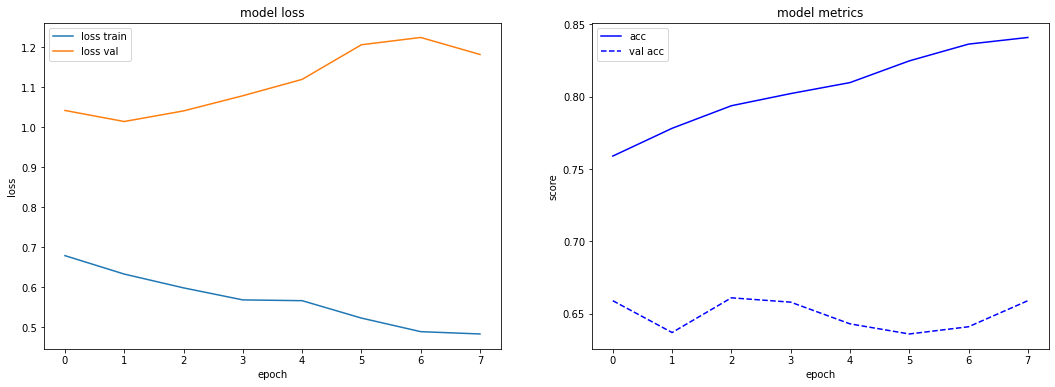

In [103]:
babysit(history_ap_4)

In [109]:
# Evaluate the model
f1.update_state(y_test_encoded, model_ap_4.predict(X_test))
f1_model_ap_4 = round(f1.result().numpy(),2)
print('F1: %f' % (f1_model_ap_4))

F1: 0.620000


## 7) Conclusion

In [132]:
result = {
    "baseline" : f1_baseline,
    "baseline_sp" : f1_baseline_sp,
    "approche_1" : f1_ap_1,
    "approche_2" : f1_ap_2,
    "appoche_3" : f1_ap_3,
    "approche_4" : f1_model_ap_4
}
result

{'baseline': 0.7,
 'baseline_sp': 0.68,
 'approche_1': 0.65,
 'approche_2': 0.61,
 'appoche_3': 0.55,
 'approche_4': 0.62}

<AxesSubplot:xlabel='model'>

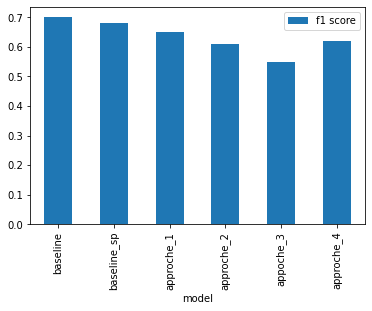

In [133]:
df = pd.DataFrame({"model":[i for i in result.keys()], 
"f1 score":[i for i in result.values()]})

df.plot(x="model", y="f1 score", kind="bar")